<a href="https://colab.research.google.com/github/uyangas/Visualizations-in-Python/blob/main/Google_play_store_app_seaborn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Play Store App Data Visualization (Seaborn)

https://www.kaggle.com/lava18/google-play-store-apps

In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 4.5MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=f8405b534f17304ba326303a37a9d1999622767986ef42851128b83256809e5a
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


## 1. Download the datasets

In [ ]:
from google.colab import files
files.upload()

In [2]:
!mkdir ~/.kaggle

In [3]:
# save kaggle.json to "kaggle" directory
! cp kaggle.json ~/.kaggle/

In [4]:
# change the permission of the file
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
# download the dataset
! kaggle datasets download -d lava18/google-play-store-apps --force

  0% 0.00/1.94M [00:00<?, ?B/s]
100% 1.94M/1.94M [00:00<00:00, 65.3MB/s]


In [6]:
# create directory to unzip the data
! mkdir ~/.google_play_store

In [7]:
! unzip google-play-store-apps.zip -d google_play_store

Archive:  google-play-store-apps.zip
  inflating: google_play_store/googleplaystore.csv  
  inflating: google_play_store/googleplaystore_user_reviews.csv  
  inflating: google_play_store/license.txt  


In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## 2. Data preprocessing

In [51]:
ps = pd.read_csv("google_play_store/googleplaystore.csv")
review = pd.read_csv("google_play_store/googleplaystore_user_reviews.csv")
ps.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [52]:
print(f"The size of the play store dataset: {ps.shape}, The size of the review dataset: {review.shape}")

The size of the play store dataset: (10841, 13), The size of the review dataset: (64295, 5)


In [53]:
ps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


The imported data type of some of the variables such as `Price` and `Reviews` were objects. To perform calculations on some of the variables, `Price` was converted to numerical `float` value after `$` was removed, `Reviews` was converted to `int` and `Last Updated` was converted to `datetime` data type.

In [54]:
def change_datatype(df):
  '''
  Fixes column problem of a data point and converts the columns to corresponding datatypes

  params: dataframe
  outcome: dataframe

  '''

  values = list(df.iloc[10472,:])
  values.insert(1, values.pop(12))
  df.iloc[10472,:] = values

  df['Price'] = df['Price'].str.strip('$').astype('float')
  df['Reviews'] = df['Reviews'].astype('int')

  df['Last Updated'] = pd.to_datetime(df['Last Updated'])

  return df

In [55]:
ps = change_datatype(ps)
ps.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0.0,Everyone,Art & Design,2018-01-07,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0.0,Everyone,Art & Design,2018-08-01,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0.0,Teen,Art & Design,2018-06-08,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0.0,Everyone,Art & Design;Creativity,2018-06-20,1.1,4.4 and up


In the `ps` dataset, app names were duplicated. Total of 798 apps were duplicated. Some of the apps belonged to 2 categories or the number of reviews differed a bit. Therefore, to remove the duplicated values, the first values of each duplicated app was taken.

In [56]:
duplicated = ps[['App','Category']].groupby('App').count().sort_values(ascending=False, by='Category').reset_index().rename({"Category":"Number of duplications"},axis=1)
duplicated[duplicated['Number of duplications']>1].head()

,App,Number of duplications
0,ROBLOX,9
1,"CBS Sports App - Scores, News, Stats & Watch Live",8
2,Duolingo: Learn Languages Free,7
3,ESPN,7
4,8 Ball Pool,7


In [57]:
df = pd.DataFrame()
for row in duplicated[duplicated['Number of duplications']>1]['App'].values:
  df = pd.concat([df, ps[ps['App'] == row].iloc[0,:]], axis=1)

In [58]:
df = df.T
ps = ps.loc[[True if row not in duplicated[duplicated['Number of duplications']>1]['App'].values else False for row in ps['App']],:]
ps = pd.concat([ps, df], axis=0)
ps.reset_index(inplace=True)

`Rating` had 1463 `NA` values which were not removed. `NA` values were ignored in the calculations.

In [59]:
ps.isna().sum()

index                0
App                  0
Category             1
Rating            1463
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       0
Genres               1
Last Updated         0
Current Ver          8
Android Ver          2
dtype: int64

`review` dataset contains the review text and the sentiments of the reviews. 

In [60]:
review.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


`review` dataset contains rows with many `NA` values. 41.7% of the rows didn't have any values. These rows were dropped.

In [61]:
review.isna().sum()

App                           0
Translated_Review         26868
Sentiment                 26863
Sentiment_Polarity        26863
Sentiment_Subjectivity    26863
dtype: int64

In [62]:
review.dropna(inplace=True)
print(f"Shape of review dataset after NAs dropped: {review.shape}")

Shape of review dataset after NAs dropped: (37427, 5)


The number of apps in `review` dataset is less than that was in `ps` dataset. 1020 apps had reviews.

In [63]:
print(f"Total number of apps: {len(ps['App'].unique())}")
print(f"Number of apps with reviews: {len(review['App'].unique())}")
print(f"Number of apps with reviews available: {len(np.intersect1d(review['App'].unique(), ps['App'].unique()))}")

Total number of apps: 9660
Number of apps with reviews: 865
Number of apps with reviews available: 816


## 3. Exploratory Data Analysis

The exploratory data analysis is conducted to offer answers to the following questions.
1. What is the definition of successful app?
2. What makes the app successful?
3. What are the characteristics of the most successful and unsuccessful apps?
4. Does reviews matter and how much it matters?

### 3.1. What defines the success of an app?

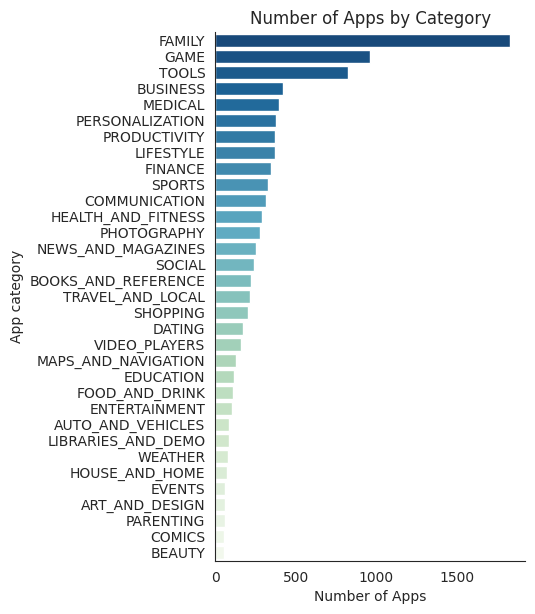

In [64]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(4,7), dpi=100)
ax = sns.countplot(y='Category', data=ps[['Category','Type']],  
            order=ps[['Category','Type']].groupby('Category').count().sort_values(by='Type',ascending=False).index,
            palette='GnBu_r')
ax.set_title("Number of Apps by Category")
ax.set_xlabel("Number of Apps")
ax.set_ylabel("App category")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

The most apps are `Family` apps and followed by `Game` and `Tools` apps. 

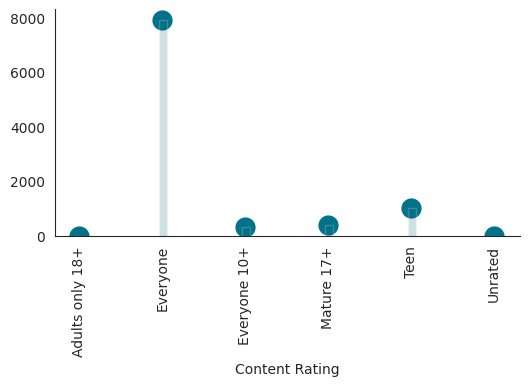

In [124]:
cont_rating = ps.groupby('Content Rating').agg({'App':'count'}).reset_index()

fig, ax = plt.subplots(figsize=(6,3), dpi=100)
sns.barplot(x=cont_rating['Content Rating'], y= cont_rating['App'], ax=ax, color='#017289', alpha=0.2, edgecolor=None)

for bar in ax.patches:
  x = bar.get_x()
  width = bar.get_width()
  centre = x+width/2.
  bar.set_x(centre-width/20.)
  bar.set_width(0.1)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

sns.scatterplot(x=cont_rating['Content Rating'], y= cont_rating['App'], ax=ax, s=250, color='#017289')

ax.set_ylabel("")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

The majority of the apps are designed for people of all ages and there are very few apps for `Adults only 18+` and `Mature 17+`.

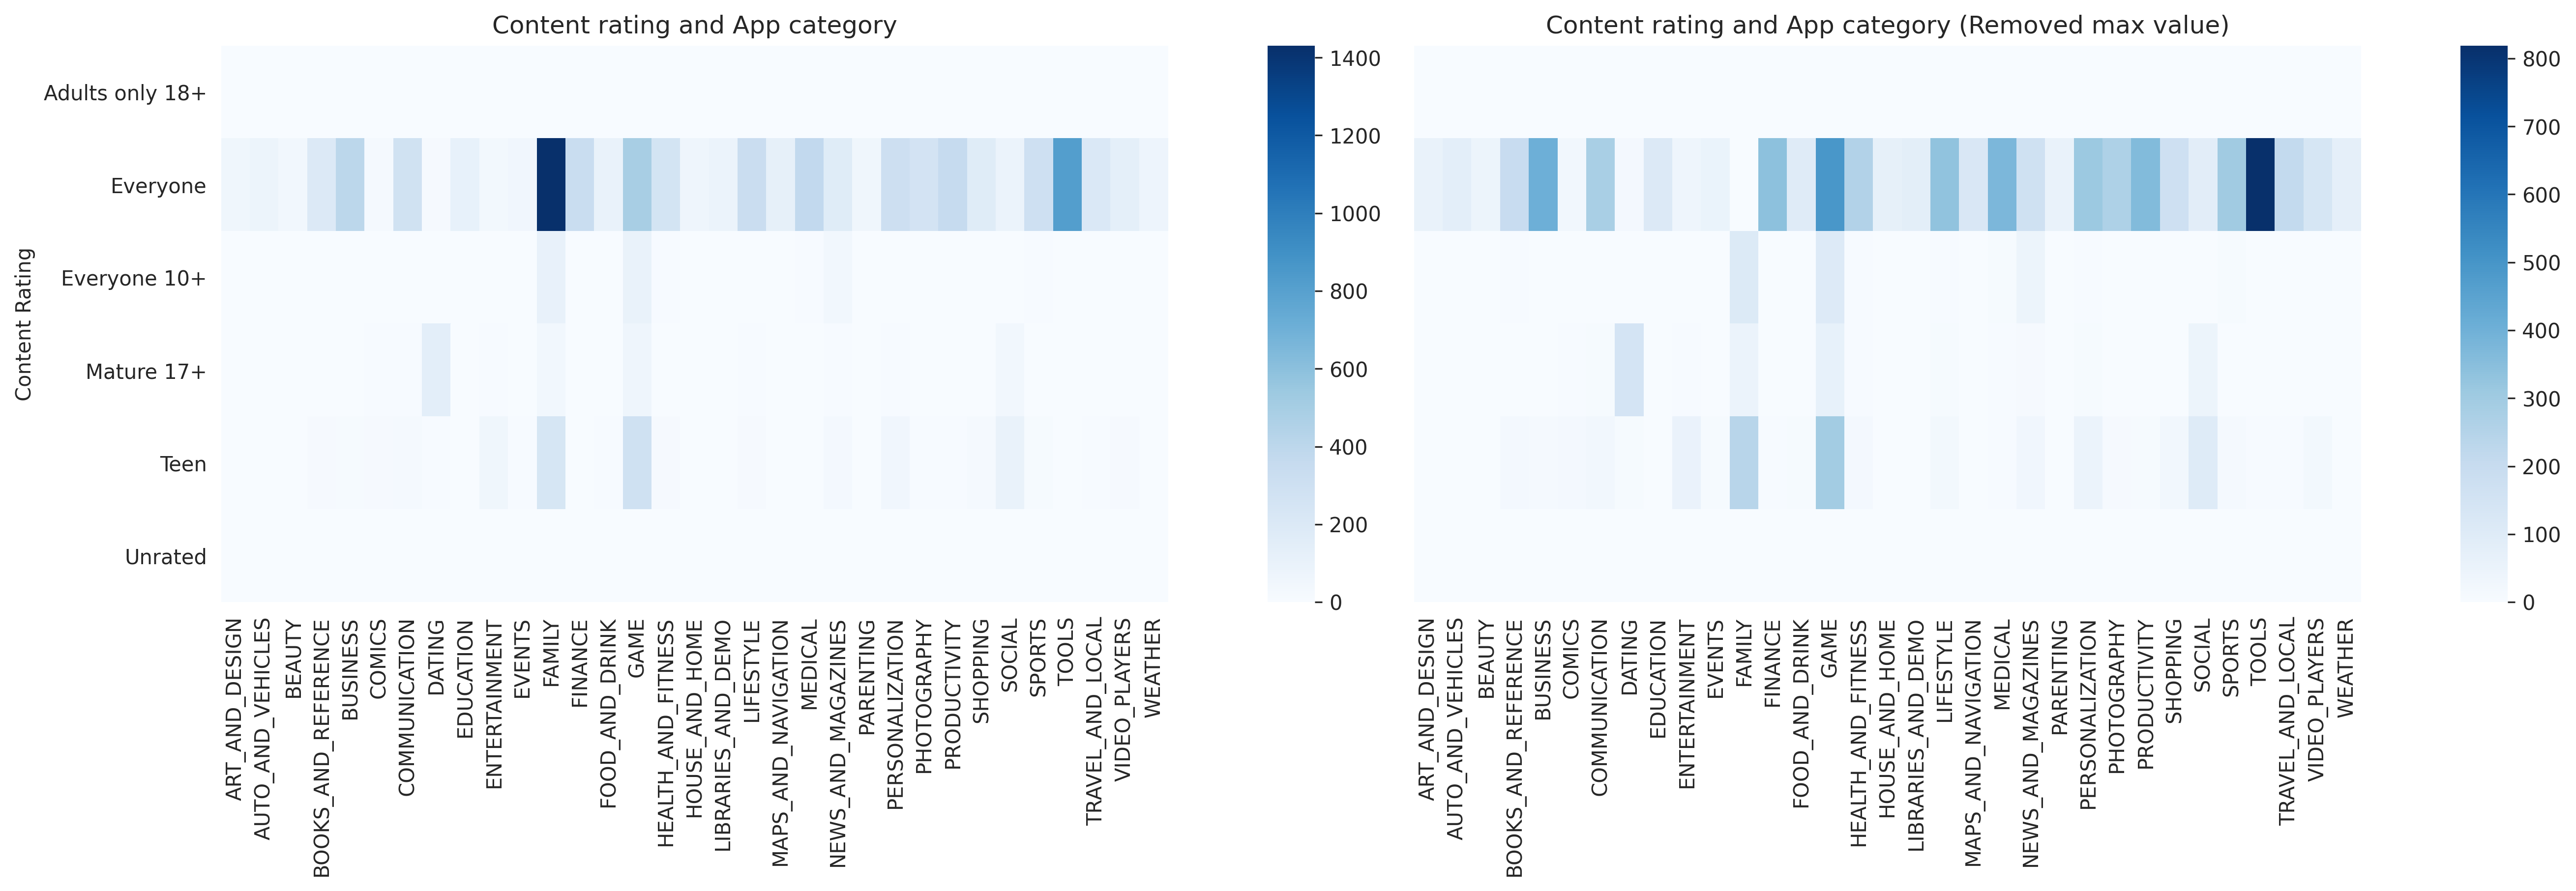

In [66]:
app_cnt = ps.groupby(['Category', 'Content Rating']).agg({'App':'count'}).reset_index().pivot('Content Rating','Category','App').fillna(0)

f,(ax1, ax1cb, ax2, ax2cb) = plt.subplots(1,4, 
            gridspec_kw={'width_ratios':[1,0.05,1,0.05]},
            figsize=(20,5),
            dpi=300)
ax1.get_shared_y_axes().join(ax2)

g1 = sns.heatmap(app_cnt, ax=ax1, cbar_ax=ax1cb, cmap='Blues')

app_cnt.loc['Everyone', 'FAMILY'] = 0

g2 = sns.heatmap(app_cnt, ax=ax2, cbar_ax=ax2cb, cmap='Blues')
g2.set_yticklabels("")
g1.set_xlabel("")
g2.set_xlabel("")
g2.set_ylabel("")
g2.set_yticks([])
g1.set_title("Content rating and App category")
g2.set_title("Content rating and App category (Removed max value)")

for ax in [g1,g2]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=90)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)

plt.show()

If we look at the `Category` and `Content Rating` cross heatmap, we can see that `entertainment`, `family`, `gaming` and `social` apps mostly developed for `teens`.

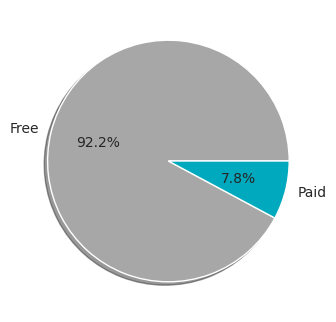

In [67]:
fig, ax = plt.subplots(dpi=100)
ax.pie(dict(ps['Type'].value_counts()).values(), 
       labels =dict(ps['Type'].value_counts()).keys(), 
       autopct='%1.1f%%', 
       colors=['#A7A7A7','#00A9BD'], 
       shadow=True)
fig.show()

92.2% of all the apps are free and only 7.8% are paid apps. 

Text(0, 0.5, '')

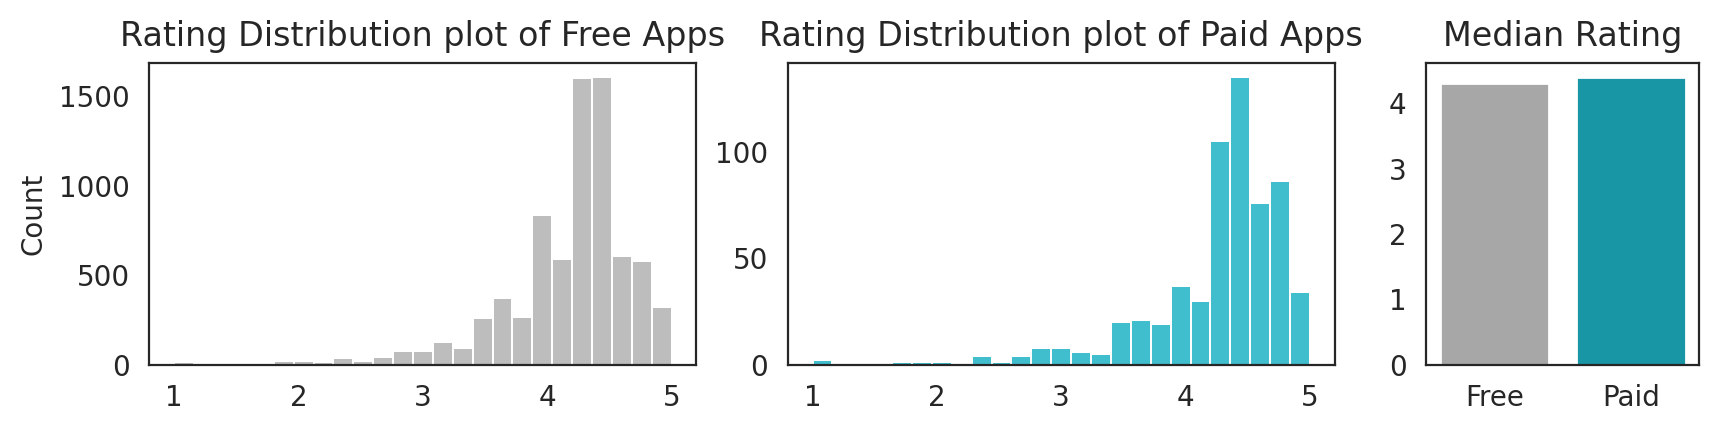

In [68]:
app_rate = ps[~ps.Rating.isna()].astype({'Rating':'float'})

fig, (ax1, ax2, ax3) = plt.subplots(1,3, 
                                    figsize=(10,2),
                                    gridspec_kw={'width_ratios':[2,2,1]},
                                    dpi=200)

sns.histplot(x='Rating', data=app_rate[app_rate['Type'] == 'Free'], 
             ax=ax1, 
             color='#A7A7A7',
             bins=25)
sns.histplot(x='Rating', data=app_rate[app_rate['Type'] == 'Paid'], 
             ax=ax2, 
             color='#00A9BD',
             bins=25)
sns.barplot(x='Type', y='Rating', data=app_rate, 
                ci=False, estimator=np.median,
            ax=ax3,
            palette=['#A7A7A7','#00A9BD'])

ax1.set_title("Rating Distribution plot of Free Apps")
ax2.set_title("Rating Distribution plot of Paid Apps")
ax3.set_title("Median Rating")
ax1.set_xlabel("")
ax2.set_xlabel("")
ax2.set_ylabel("")
ax3.set_xlabel("")
ax3.set_ylabel("")

If we look at the `Rating` of free and paid apps, they both have similar median ratings, free apps - 4.3 and paid apps - 4.4. Since the distribution of rating is left skewed, the median was used from here on after when comparisons were made.

In [69]:
ps['Size'] = [float(i.strip('k'))/1024 if i.find('k') > 0 else i.strip('M') for i in ps.Size]
ps['review_perc'] = ps['Reviews']/ ps['Installs'].str.replace('+',"").str.replace(',',"").astype('int')

bins = [-1, 1.5, 2.5, 3.5, 4.5, np.inf]
ps['Rating_bin'] = pd.cut(ps['Rating'].fillna(0).astype('float'), bins, labels=['1. <1.5','2. 1.5-2.5','3. 2.5-3.5','4. 3.5-4.5','5. 4.5<'])

ps.head().T

,0,1,2,3,4
index,0,2,3,4,5
App,Photo Editor & Candy Camera & Grid & ScrapBook,"U Launcher Lite – FREE Live Cool Themes, Hide ...",Sketch - Draw & Paint,Pixel Draw - Number Art Coloring Book,Paper flowers instructions
Category,ART_AND_DESIGN,ART_AND_DESIGN,ART_AND_DESIGN,ART_AND_DESIGN,ART_AND_DESIGN
Rating,4.1,4.7,4.5,4.3,4.4
Reviews,159,87510,215644,967,167
Size,19,8.7,25,2.8,5.6
Installs,"10,000+","5,000,000+","50,000,000+","100,000+","50,000+"
Type,Free,Free,Free,Free,Free
Price,0,0,0,0,0
Content Rating,Everyone,Everyone,Teen,Everyone,Everyone


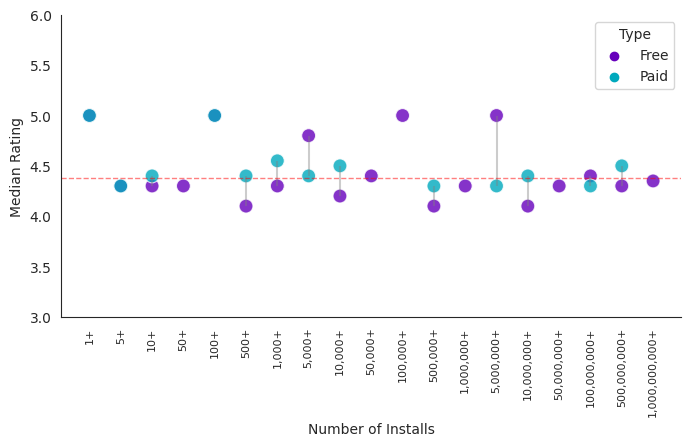

In [233]:
order_app = ['1+', '5+','10+','50+','100+', '500+','1,000+','5,000+',
             '10,000+','50,000+','100,000+','500,000+','1,000,000+','5,000,000+',
             '10,000,000+', '50,000,000+', '100,000,000+','500,000,000+', '1,000,000,000+']

installs = app_rate.groupby(['Installs','Type']).agg({'Rating':'median'}).reset_index()
installs_diff = installs.groupby('Installs').agg({'Rating':'max'})
installs_diff['min'] = installs.groupby('Installs').agg({'Rating':'min'}).Rating

fig, ax = plt.subplots(figsize=(8,4), dpi=100)
sns.scatterplot(x='Installs',
                y='Rating',
                data =installs,
                hue='Type',
                palette=['#6700BC', '#00A9BD'],
                s=100,
                alpha=0.8,
                ax=ax)

ax.vlines(x=installs_diff.index, 
          ymin=installs_diff['min'], 
          ymax=installs_diff['Rating'], 
          color='grey', 
          alpha=0.4)

ax.axhline(installs.Rating.median(), color='red', alpha=0.5, linestyle='--', linewidth=1)

ax.set_xticklabels(order_app,rotation=90, fontsize=8)
ax.set_xlabel("Number of Installs")
ax.set_ylabel("Median Rating")
ax.set_ylim(3,6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Number of installs doesn't effect much on `Rating`. As the number of installs grows, meaning as the app becomes popular, the rating gap between free and paid apps gets smaller. For apps that have less than 10,000 installs, the gap between free and paid is greater than those apps with higher number of installs. This suggests that as the app gets popular, so does the development of the program and contents.

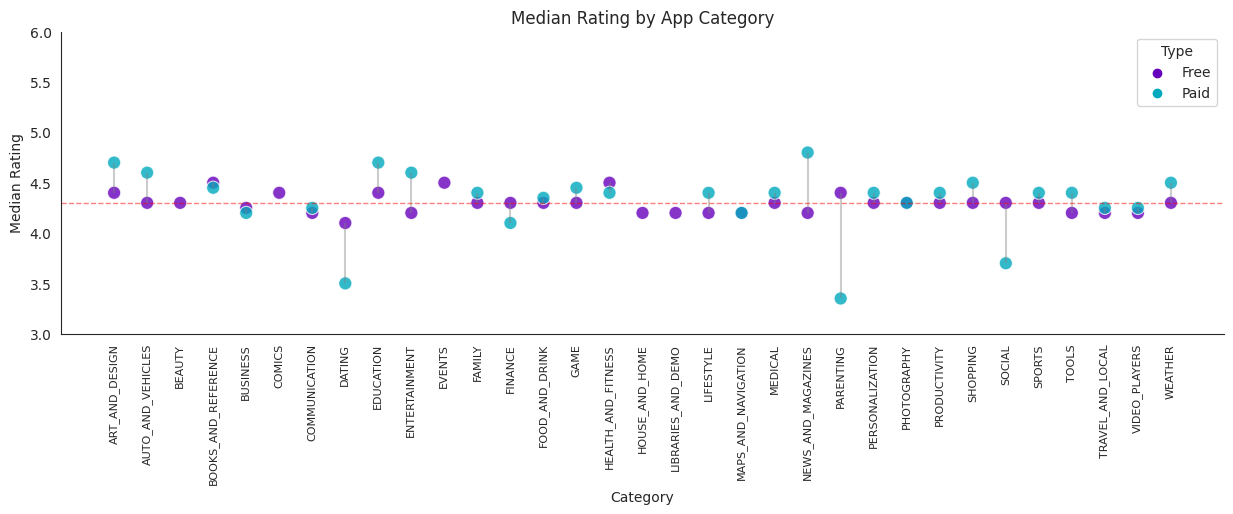

In [244]:
cat_rating = app_rate.groupby(['Category','Type']).agg({'Rating':'median'}).reset_index()
cat_rating_diff = cat_rating.groupby('Category').agg({'Rating':'max'})
cat_rating_diff['min'] = cat_rating.groupby('Category').agg({'Rating':'min'}).Rating

fig, ax = plt.subplots(figsize=(15,4), dpi=100)
sns.scatterplot(x='Category',
                y='Rating',
                data =cat_rating,
                hue='Type',
                palette=['#6700BC', '#00A9BD'],
                s=90,
                alpha=0.8,
                ax=ax)

ax.vlines(x=cat_rating_diff.index, 
          ymin=cat_rating_diff['min'], 
          ymax=cat_rating_diff['Rating'], 
          color='grey', 
          alpha=0.4)

ax.axhline(cat_rating.Rating.median(), color='red', alpha=0.5, linestyle='--', linewidth=1)

ax.set_xticklabels(cat_rating_diff.index, rotation=90, fontsize=8)
ax.set_xlabel("Category")
ax.set_ylabel("Median Rating")
ax.set_title("Median Rating by App Category")
ax.set_ylim(3,6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

`Beauty`, `Comics`, `House and home` and `Libraries and demo` categories didn't have any paid apps. 

`Dating`, `Finance`, `Parenting` and `Social` categories have lower median rating for paid apps compared to the free ones. 

`Business`, `Communication`, `Maps and navigation`, `Travel and local` and `Video Players` categories have median app rating below overall median rating.

Other categories have above overal median rating ratings. 

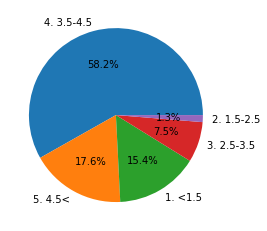

In [142]:
fig, ax = plt.subplots()
ax.pie(dict(ps['Rating_bin'].value_counts()).values(), 
       labels = dict(ps['Rating_bin'].value_counts()).keys(),
       autopct='%1.1f%%')
fig.show()

To be continued